# Section 6 Lecture 31: TensorFlow Regression Example

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [32]:
# we want a big data set this time
x_data = np.linspace(0.0,10.0,1000000)
noise = np.random.randn(len(x_data))

In [33]:
#noise
#x_data

$y = mx + b$

$b = 5$

In [34]:
y_true = (0.5 * x_data) + 5 + noise # add some noise so it's not a perfect line

In [35]:
#Use pandas to make charts and other ops easier

In [36]:
x_df = pd.DataFrame(data=x_data,columns=['X Data'])
y_df = pd.DataFrame(data=y_true,columns=['Y'])

In [37]:
# now concatenate 2 data frames
my_data = pd.concat([x_df, y_df], axis=1) # join them on columns rather than as "pancakes"

In [38]:
# my_data.plot() # too much data, we may crash factory

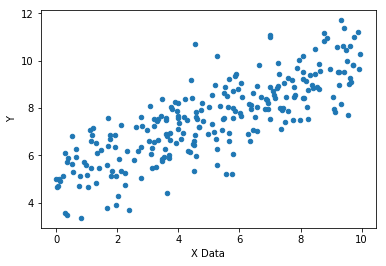

In [39]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')

In [40]:
# ^^^ linear trend but not straight because we've added noise
# can we get TF to find a line here? We know intercept should be ~5 
# and slope should be 0.5
# But we can't feed 1mm points to TF, we have to batch it

Steps to using TF:
* Define constants
* Define variables
* Define placeholders
* Define model
* define graph
* define loss function
* define optimizer

In [41]:
batch_size = 8 # grab 8 pts at a time, choosing it is an art

In [42]:
np.random.randn(2)

array([-0.71134832,  0.13815863])

In [43]:
m = tf.Variable(-0.00361972)
b = tf.Variable(-1.4707748)

In [44]:
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

In [45]:
y_model = m*xph + b

In [46]:
# define loss function
# we could use **2 but use tf function for consistency with documentation
error = tf.reduce_sum(tf.square(yph-y_model))

In [47]:
# Now define optimizer and training
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

In [48]:
init = tf.global_variables_initializer()

In [49]:
# test passing an array (rather than a scalar) as an index
multi_index = range(0,100,7)
x_data[multi_index]
# it works!

array([0.0000000e+00, 7.0000070e-05, 1.4000014e-04, 2.1000021e-04,
       2.8000028e-04, 3.5000035e-04, 4.2000042e-04, 4.9000049e-04,
       5.6000056e-04, 6.3000063e-04, 7.0000070e-04, 7.7000077e-04,
       8.4000084e-04, 9.1000091e-04, 9.8000098e-04])

In [91]:
val = []
with tf.Session() as sess:
    sess.run(init) # we need to initialize locals as well as globals [why??]
    # run "some" batches
    # 8,000 samples _should_ be enough
    batches = 1000
    for i in range(batches):
        # rand_ind is fetch random indexes of the data
        rand_ind = np.random.randint(len(x_data), size=batch_size)
        # fill the random index points into the TF graph
        feed_dict = {xph:x_data[rand_ind], yph:y_true[rand_ind]}
        # Now train with these random points
        sess.run(train,feed_dict)
        model_m, model_b = sess.run([m,b])
        val.append((model_m,model_b,i))
    

    print(f'len {len(val)} 0={val[0]} last={val[-1]}')

len 1000 0=(0.8616942, -1.3213968, 0) last=(0.5006944, 4.9138227, 999)


In [92]:
from mpl_toolkits.mplot3d import Axes3D

0.5006944 4.9138227 10


(0, 999)

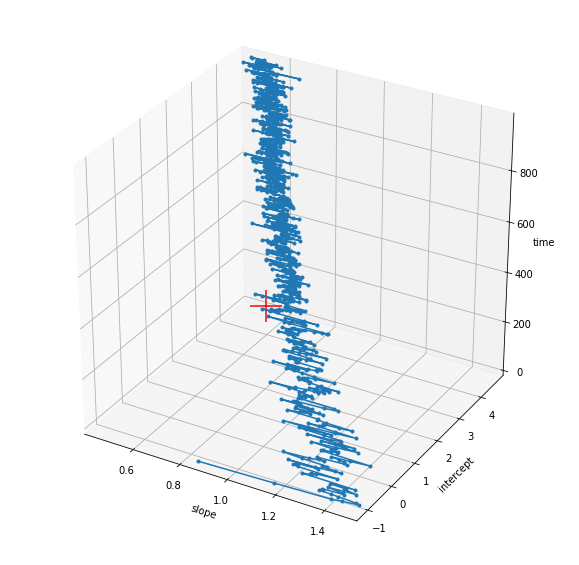

In [95]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
val_x,val_y,val_z = list(zip(*val))
plt.plot(val_x,val_y,val_z,marker='.')
plt.scatter(val_x[-1],val_y[-1],val_z[-1],c='r', marker='+')
print(val_x[-1],val_y[-1],len(val[:10]))
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_zlabel('time')
ax.set_xlim(min(val_x),max(val_x))
ax.set_ylim(min(val_y),max(val_y))
ax.set_zlim(min(val_z),max(val_z))

In [96]:
# We started with orig slope of 0.5 then preturbed it with noise so m should be close to 0.5
# Likewise, b started close to 5, so it should end up being close to 5
print(f'm={model_m} b={model_b}')

m=0.5006943941116333 b=4.913822650909424


(0, 14.04591734894454)

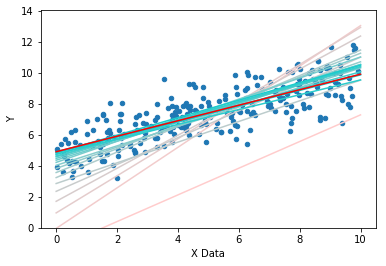

In [136]:
# now we visualize
y_hat = x_data * model_m + model_b
my_data.sample(250).plot(kind='scatter',x='X Data', y='Y')
my_val_samples = np.array(val)[np.linspace(0,len(val)-1,10,dtype=int)]#.sample(10)
for points in my_val_samples:
    _y_hat = x_data * points[0] + points[1]
    _col = 1-(points[2] / len(val))
    plt.plot(x_data, _y_hat, color=(_col, .8, .8))
plt.plot(x_data, y_hat, 'r')
plt.ylim(0,my_data.Y.max())